In [1]:
import numpy as np
from scipy import optimize
from scipy import interpolate
import matplotlib as mpl
import matplotlib.pyplot as plt
import sympy as sm
sm.init_printing(use_unicode=True) # for pretty printing

# 1. Human capital accumulation

Consider a worker living in **two periods**, $t \in \{1,2\}$. 

In each period she decides whether to **work ($l_t = 1$) or not ($l_t = 0$)**. 

She can *not* borrow or save and thus **consumes all of her income** in each period. 

If she **works** her **consumption** becomes:

$$c_t = w h_t l_t\,\,\text{if}\,\,l_t=1$$

where $w$ is **the wage rate** and $h_t$ is her **human capital**. 

If she does **not work** her consumption becomes:

$$c_t = b\,\,\text{if}\,\,l_t=0$$

where $b$ is the **unemployment benefits**.

Her **utility of consumption** is: 

$$ \frac{c_t^{1-\rho}}{1-\rho} $$

Her **disutility of working** is:

$$ \gamma l_t $$

From period 1 to period 2, she **accumulates human capital** according to:

$$ h_2 = h_1 + l_1 + 
\begin{cases}
0 & \text{with prob. }0.5 \\
\Delta & \text{with prob. }0.5 
\end{cases} \\
$$

where $\Delta$ is a **stochastic experience gain**.

In the **second period** the worker thus solves:

$$
\begin{eqnarray*}
v_{2}(h_{2}) & = &\max_{l_{2}} \frac{c_2^{1-\rho}}{1-\rho} - \gamma l_2
\\ & \text{s.t.} & \\
c_{2}& = & w h_2 l_2 \\
l_{2}& \in &\{0,1\}
\end{eqnarray*}
$$

In the **first period** the worker thus solves:

$$
\begin{eqnarray*}
v_{1}(h_{1}) &=& \max_{l_{1}} \frac{c_1^{1-\rho}}{1-\rho} - \gamma l_1 + \beta\mathbb{E}_{1}\left[v_2(h_2)\right]
\\ & \text{s.t.} & \\
c_1 &=& w h_1 l_1 \\
h_2 &=& h_1 + l_1 + \begin{cases}
0 & \text{with prob. }0.5\\
\Delta & \text{with prob. }0.5 
\end{cases}\\
l_{1} &\in& \{0,1\}\\
\end{eqnarray*}
$$

where $\beta$ is the **discount factor** and $\mathbb{E}_{1}\left[v_2(h_2)\right]$ is the **expected value of living in period two**.

The **parameters** of the model are:

In [2]:
rho = 2
beta = 0.96
gamma = 0.1
w = 2
b = 1
Delta = 0.1

The **relevant levels of human capital** are:

In [3]:
h_vec = np.linspace(0.1,1.5,100)

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital). 

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Question 1:** Solve the model in period 2 and illustrate the solution (including labor supply as a function of human capital).

**Method:** To solve the questions I firstly compute some relevant functions. I believe there is a mistake in the optimization problems and I will work with the problems with $c_t = wh_tl_t + b(1-l_t)$. To solve the model in period 2 I compare the utility in period 2 for l2 = 0 and l2 = 1 for each value of human capital. The l2 that maximizes the utility is saved in a vector.

In [4]:
# create basic functions

# utility
def utility(c, rho):
    return c**(1 - rho)/(1 - rho)

# disutility
def disutility(gamma, l):
    return gamma*l

# consumption
def cons(w, h, b, l):
    return w*h*l + b*(1 - l)

# utility in period 2
def v2(l2, w, b, h2, rho, gamma):
    return utility(cons(w, h2, b, l2), rho) - disutility(gamma, l2)

# utility in period 1
def v1(l1, w, b, rho, gamma, h1, Delta, beta, v2_interp):
    """   
    returns the (net)utility in period 1
    
    parameters: see model description
    
    """
    # a. v2 if 0 extra human capital
    h2_low = h1 + l1
    v2_low = v2_interp([h2_low])[0]
    
    # b. v2 if Delta extra human capital
    h2_high = h1 + l1 + Delta
    v2_high = v2_interp([h2_high])[0]
    
    # c. expected v2 value
    v2 = 0.5*v2_low + 0.5*v2_high
    
    # d. total net utility
    return utility(cons(w, h1, b, l1), rho) - disutility(gamma, l1) + beta*v2

Text(0.5, 1.0, 'labor supply in period 2')

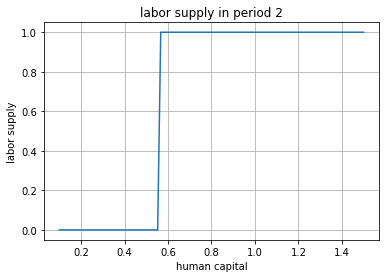

In [5]:
# a. create function to solve the problem in period 2
def solve_period_2(rho, w, b, h_vec, gamma, Delta):
    """   
    returns the labor supply and utility in period 2 (v2, l2) for different levels of human capital
    
    parameters: see model description
    """
    # i. define vectors
    v2_vec = np.empty(100)
    l2_vec = np.empty(100, dtype=int)

    # ii. solve for each h in h_vec
    for i,h in enumerate(h_vec):
       
        # 1. compare v2 for l2 = 0 and l2 = 1 and return the l2 that maximizes v2
        if (v2(0, w, b, h, rho, gamma) > v2(1, w, b, h, rho, gamma)) == True:
            l2_vec[i] = 0
        else:
            l2_vec[i] = 1
        
        # 2. append the v2 value from the optimized l2 for each h
        v2_vec[i] = v2(l2_vec[i], w, b, h, rho, gamma)
               
    return v2_vec, l2_vec

# b. use the function to solve the model in period 2
v2_vec, l2_vec = solve_period_2(rho, w, b, h_vec, gamma, Delta)

# c. plot period 2 solution
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(h_vec, l2_vec)

# d. set grids
ax.grid()
    
# e. set labels
ax.set_ylabel('labor supply')
ax.set_xlabel('human capital')

# f. set title
ax.set_title('labor supply in period 2')

**Answer:** The labor supply in period 2 is positive as long as the level of human capital is high enough. With these parameters it is positive for human capital larger than around 0.5. The higher human capital makes it more profitable to work according to the consumption function.

**Question 2:** Solve the model in period 1 and illustrate the solution (including labor supply as a function of human capital). 

**Method:** The procedure is much the same as in period 2 but firstly the utility of period 2 needs to be interpolated as it should be taking into account in the period 1 optimization. The accumulation of human capital from period 1 to 2 is modelled in the utility function of period 1 where the two cases of extra stochastic gain is weighted with the probabilities.

Text(0.5, 1.0, 'labor supply in period 1')

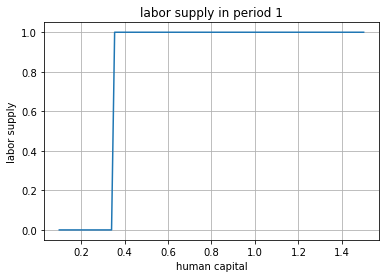

In [6]:
# a. interpolate utility from period 2
v2_interp = interpolate.RegularGridInterpolator((h_vec,), v2_vec,
                                                    bounds_error=False,fill_value=None)

# b. create functionto solve problem in period 1
def solve_period_1(w, b, rho, gamma, h_vec, Delta, beta, v2_interp):
    """   
    returns the labor supply and utility in period 1 (v1, l1) for different levels of human capital
    
    parameters: see model description
    """
    # i. define grids
    v1_vec = np.empty(100)
    l1_vec = np.empty(100, dtype=int)
    
    # ii. solve for each h in grid
    for i,h in enumerate(h_vec):
       
        # 1. compare v1 for l1 = 0 and l1 = 1 and return the l1 that maximizes v1
        if (v1(0, w, b, rho, gamma, h, Delta, beta, v2_interp) 
            > v1(1, w, b, rho, gamma, h, Delta, beta, v2_interp)) == True:
            l1_vec[i] = 0
        else:
            l1_vec[i] = 1
        
        # 2. append the v1 value from the optimized l1
        v1_vec[i] = v1(l1_vec[i], w, b, rho, gamma, h, Delta, beta, v2_interp)
               
    return v1_vec, l1_vec

# c. use the function to solve the model in period 1
v1_vec, l1_vec = solve_period_1(w, b, rho, gamma, h_vec, Delta, beta, v2_interp)

# d. illustrate period 1 solution
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(h_vec, l1_vec)

# e. adjust plot
ax.grid()
ax.set_ylabel('labor supply')
ax.set_xlabel('human capital')
ax.set_title('labor supply in period 1')

**Answer:** For period 1 the labor supply is positive for a lower level of human capital relative to period 2. This happens as there is a potential experience gain of working in period 1 which makes it more attractive to work.

**Question 3:** Will the worker never work if her potential wage income is lower than the unemployment benefits she can get? Explain and illustrate why or why not.

**Method:** As the labor suppy is higher in period 1 relative to period 2 for the same parameters, I examine only the labor suppy in period 1. If she never wants to work for $w < b$ in period 1, she won't do it in period 2 either. Also I only look at the highest value of human capital, as if she never want to work for that level of human capital, she never wants to at all. 
I define a vector of benefits >= w and examine if the labor supply is positive for some of the benefits larger than w. 

Text(0.5, 1.0, 'labor supply in period 1 for different levels of benefits with h=1.5 and w=2')

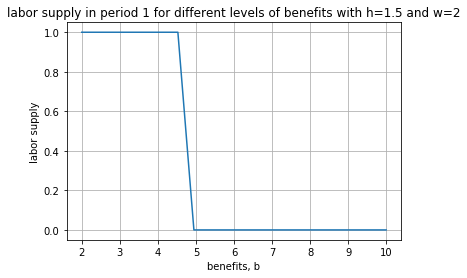

In [7]:
# a. define a vector of b where b >= w = 2
b_vec = np.linspace(2, 10, 20)

# b. define vector 
l1_vec_q3 = np.empty(len(b_vec), dtype = int)

# c. compare v1 for l1 = 0 and l1 = 1 and return the l1 that maximizes v1
for i in range(len(b_vec)):
    if (v1(0, w, b_vec[i], rho, gamma, h_vec[99], Delta, beta, v2_interp) 
        > v1(1, w, b_vec[i], rho, gamma, h_vec[99], Delta, beta, v2_interp)) == True:
        l1_vec_q3[i] = 0
    else:
        l1_vec_q3[i] = 1

# d. illustrate period 1 result
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(b_vec, l1_vec_q3)

# e. adjust plot
ax.grid()
ax.set_ylabel('labor supply')
ax.set_xlabel('benefits, b')
ax.set_title('labor supply in period 1 for different levels of benefits with h=1.5 and w=2')

**Answer:** From this we see that, there are parameters for which she will work although the benefits are higher than the wage $(b > w)$. For this to happen it is necessary that the level of human capital is high enough as it boosts the consumption when working. We can only conclude that it can be optimal for her to work in period 1, this doesn't imply she wants to work in period 2 as well.

# 2. AS-AD model

Consider the following **AS-AD model**. The **goods market equilibrium** is given by

$$ y_{t} = -\alpha r_{t} + v_{t} $$

where $y_{t}$ is the **output gap**, $r_{t}$ is the **ex ante real interest** and $v_{t}$ is a **demand disturbance**. 

The central bank's **Taylor rule** is

$$ i_{t} = \pi_{t+1}^{e} + h \pi_{t} + b y_{t}$$

where $i_{t}$ is the **nominal interest rate**, $\pi_{t}$ is the **inflation gap**, and $\pi_{t+1}^{e}$ is the **expected inflation gap**. 

The **ex ante real interest rate** is given by 

$$ r_{t} = i_{t} - \pi_{t+1}^{e} $$

Together, the above implies that the **AD-curve** is

$$ \pi_{t} = \frac{1}{h\alpha}\left[v_{t} - (1+b\alpha)y_{t}\right]$$

Further, assume that the **short-run supply curve (SRAS)** is given by

$$ \pi_{t} = \pi_{t}^{e} + \gamma y_{t} + s_{t}$$

where $s_t$ is a **supply disturbance**.

**Inflation expectations are adaptive** and given by

$$ \pi_{t}^{e} = \phi\pi_{t-1}^{e} + (1-\phi)\pi_{t-1}$$

Together, this implies that the **SRAS-curve** can also be written as

$$ \pi_{t} = \pi_{t-1} + \gamma y_{t} - \phi\gamma y_{t-1} + s_{t} - \phi s_{t-1} $$

The **parameters** of the model are:

In [8]:
par = {}

par['alpha'] = 5.76
par['h'] = 0.5
par['b'] = 0.5
par['phi'] = 0
par['gamma'] = 0.075

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Persistent disturbances:** Now, additionaly, assume that both the demand and the supply disturbances are AR(1) processes

$$ v_{t} = \delta v_{t-1} + x_{t} $$
$$ s_{t} = \omega s_{t-1} + c_{t} $$

where $x_{t}$ is a **demand shock**, and $c_t$ is a **supply shock**. The **autoregressive parameters** are:

In [9]:
par['delta'] = 0.80
par['omega'] = 0.15

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Stochastic shocks:** Now, additionally, assume that $x_t$ and $c_t$ are stochastic and normally distributed

$$ x_{t}\sim\mathcal{N}(0,\sigma_{x}^{2}) $$
$$ c_{t}\sim\mathcal{N}(0,\sigma_{c}^{2}) $$

The **standard deviations of the shocks** are:

In [10]:
par['sigma_x'] = 3.492
par['sigma_c'] = 0.2

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

**Question 1:** Use the ``sympy`` module to solve for the equilibrium values of output, $y_t$, and inflation, $\pi_t$, (where AD = SRAS) given the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$. 

**Method:** I think it is a mistake that we should look at the parameters ($\alpha$, $h$, $b$, $\alpha$, $\gamma$) and I assume it should have said ($\alpha$, $h$, $b$, $\phi$, $\gamma$).

First all the symbols is defined as sympy-variables. The relevant functions are defined and solved as an equation system of 2 equations with 2 unknowns by the sm.solve-procedure. The solution is showed both with algebra and with the given parameters.

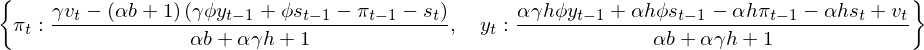

In [11]:
# a. define symbols
alpha = sm.symbols('alpha')
h = sm.symbols('h')
b = sm.symbols('b')
phi = sm.symbols('phi')
gamma = sm.symbols('gamma')
y_t = sm.symbols('y_t')
pi_t = sm.symbols('pi_t')
y_t1 = sm.symbols('y_t-1')
pi_t1 = sm.symbols('pi_t-1')
v_t = sm.symbols('v_t')
s_t = sm.symbols('s_t')
s_t1 = sm.symbols('s_t-1')

# b. define AD-curve
AD = sm.Eq(pi_t, (v_t - (1 + b*alpha)*y_t)/(h*alpha))

# c. define SRAS-curve
SRAS = sm.Eq(pi_t, pi_t1 + gamma*y_t - phi*gamma*y_t1 + s_t - phi*s_t1)

# d. solve and split solution into lists for later use
sol = sm.solve([AD, SRAS], [y_t, pi_t])
pi_sol = sol[pi_t]
y_sol = sol[y_t]

# e. make solutions to python functions for later use
pi_func = sm.lambdify((pi_t1, y_t1, v_t, s_t, s_t1, alpha, h, b, phi, gamma), pi_sol)
y_func = sm.lambdify((pi_t1, y_t1, v_t, s_t, s_t1, alpha, h, b, phi, gamma), y_sol)

# f. print result
sol

**Answer:** The expressions for $\pi_t$ and $y_t$ are both dependent of $y_{t-1}$ , $\pi_{t-1}$, $v_t$, $s_t$, and $s_{t-1}$ and all the parameters.

To get the solution with the specified parameter values see the next cell.

In [12]:
# insert parameters
alpha = par['alpha']
h = par['h']
b = par['b']
phi = par['phi']
gamma = par['gamma']

# define the curves in the same way again
AD2 = sm.Eq(pi_t, (v_t - (1 + b*alpha)*y_t)/(h*alpha))
SRAS2 = sm.Eq(pi_t, pi_t1 + gamma*y_t - phi*gamma*y_t1 + s_t - phi*s_t1)

# solve in the same way again and show the result
sol2 = sm.solve([AD2, SRAS2], [y_t, pi_t])
sol2

**Answer:** It is seen that when $\phi$ = 0 both expressions simplify and become independent of $y_{t-1}$ and $s_{t-1}$.

**Question 2:** Find and illustrate the equilibrium when $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$. Illustrate how the equilibrium changes when instead $v_t = 0.1$.

**Method:** In question 2 I found expressions for $\pi_t$ and $y_t$ in equilibrium. These were turned into python functions by the lambdify-procedure. From that the desired values of variables are inserted in the functions.

Text(0.5, 1.0, 'equilibrium for $y_{t-1} = \\pi_{t-1} = s_t = s_{t-1} = 0$ for different values of v_t')

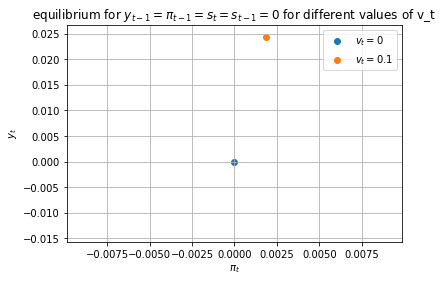

In [13]:
# a. create a vector with the different values of y, pi, v and s with the use of the equilibrium functions
pi_vec = []
pi_vec.append(pi_func(0, 0, 0, 0, 0, alpha, h, b, phi, gamma)) # v_t = 0
pi_vec.append(pi_func(0, 0, 0.1, 0, 0, alpha, h, b, phi, gamma)) # v_t = 0.1
y_vec = []
y_vec.append(y_func(0, 0, 0, 0, 0, alpha, h, b, phi, gamma)) # v_t = 0
y_vec.append(y_func(0, 0, 0.1, 0, 0, alpha, h, b, phi, gamma)) # v_t = 0.1

# b. plot the two equilibriums
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.scatter(pi_vec[0], y_vec[0], label='$v_t=0$')
ax.scatter(pi_vec[1], y_vec[1], label='$v_t=0.1$')

# c. adjust plot
ax.grid()
ax.legend()
ax.set_ylabel('$y_t$')
ax.set_xlabel('$\pi_t$')
ax.set_title('equilibrium for $y_{t-1} = \pi_{t-1} = s_t = s_{t-1} = 0$ for different values of v_t')

**Answer:** When $y_{t-1} = \pi_{t-1} = v_t = s_t = s_{t-1} = 0$ we also get $\pi_t = y_t = 0$ in equilibrium. When changing $v_t$ we see that both $\pi_t$ and $y_t$ becomes positive, but $y_t$ is much higher than $\pi_t$.

**Question 3:** Starting from $y_{-1} = \pi_{-1} = s_{-1} = 0$, how does the economy evolve for $x_0 = 0.1$, $x_t = 0, \forall t > 0$ and $c_t = 0, \forall t \geq 0$?

**Method:** I also assume that $v_{-1} = 0$.

The persistent disturbances is modelled as functions and then the model is simulated for 5 periods. The simulation updates the persistent disturbances which affect $y_t$ and $\pi_t$. These are calculated for each t by the functions as in question 2.

In [14]:
# a. define new parameters and the persistent disturbances
v_t1 = sm.symbols('v_t-1')
delta = par['delta']
omega = par['omega']
v_func = lambda v_t1,x: delta*v_t1 + x
s_func = lambda s_t1,c: omega*s_t1 + c

# b. initialize y_-1 = pi_-1 = s_-1 = v_-1 = 0
pi_vec_q3 = [0]
y_vec_q3 = [0]
v_vec = [0]
s_vec = [0]

# c. define x and c for periods: [-1, 0, 1, 2, 3]
T = 5
c = np.zeros(T)
x = np.zeros(T)
x[1] = 0.1 # set x0 = 0.1

# d. run simulation
for t in range(1,T):

    # i. update v and s
    v_vec.append(v_func(v_vec[t-1], x[t]))
    s_vec.append(s_func(s_vec[t-1], c[t]))

    # ii. compute y og pi 
    y_vec_q3.append(y_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], alpha, h, b, phi, gamma))
    pi_vec_q3.append(pi_func(pi_vec_q3[t-1], y_vec_q3[t-1], v_vec[t], s_vec[t], s_vec[t-1], alpha, h, b, phi, gamma))

# e. print the results
print(f'y evovles from period -1 to 3 as: ',['{:.3f}'.format(i) for i in y_vec_q3])
print(f'pi evovles from period -1 to 3 as: ',['{:.3f}'.format(i) for i in pi_vec_q3])

y evovles from period -1 to 3 as:  ['0.000', '0.024', '0.018', '0.013', '0.010']
pi evovles from period -1 to 3 as:  ['0.000', '0.002', '0.003', '0.004', '0.005']


**Answer:** We see that $y$ increases the most in period 0, but then decreases as t increases. $\pi$ is increasing in all periods from period 0 but very slowly (relative to y).

**Question 4:** Simulate the AS-AD model for 1,000 periods. Calculate the following five statistics:

1. Variance of $y_t$, $var(y_t)$
2. Variance of $\pi_t$, $var(\pi_t)$
3. Correlation between $y_t$ and $\pi_t$, $corr(y_t,\pi_t)$
4. Auto-correlation between $y_t$ and $y_{t-1}$, $corr(y_t,y_{t-1})$
5. Auto-correlation between $\pi_t$ and $\pi_{t-1}$, $corr(\pi_t,\pi_{t-1})$

**Method:** The stochastic process is modelled and the model is simulated much like question 3. Now the simulation is defined as a function as it would be useful in the later questions. As in question 3 I assume $y_{-1} = \pi_{-1} = s_{-1} = v_{-1} = 0$. Based on the simulations the statistics are calculated by np.var() and np.corrcoef().

In [15]:
# a. define new parameters and the stochastic process
np.random.seed(2019)
T = 1000
sigma_x = par['sigma_x']
sigma_c = par['sigma_c']
x = np.random.normal(loc = 0, scale = sigma_x, size = T)
c = np.random.normal(loc = 0, scale = sigma_c, size = T)

# b. create a simulation-function for later use
def simulation(T, phi_custom):  
    """
    returns (pi, y) for T simulations of the AS-AD model described above
    
    parameters: 
        T: number of simulations
        phi_custom: see model description of phi
    """
    # i. initialize y_-1 = pi_-1 = s_-1 = v_-1 = 0
    pi_vec_q4 = [0]
    y_vec_q4 = [0]
    v_vec = [0]
    s_vec = [0]

    # ii. run simulation
    for t in range(1,T):

        # 1. update v and s
        v_vec.append(v_func(v_vec[t-1], x[t]))
        s_vec.append(s_func(s_vec[t-1], c[t]))

        # 2. compute y og pi 
        y_vec_q4.append(y_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], 
                               alpha, h, b, phi_custom, gamma))
        pi_vec_q4.append(pi_func(pi_vec_q4[t-1], y_vec_q4[t-1], v_vec[t], s_vec[t], s_vec[t-1], 
                                 alpha, h, b, phi_custom, gamma))

    # iii. convert lists to numpy arrays
    pi_vec_q4 = np.array(pi_vec_q4)
    y_vec_q4 = np.array(y_vec_q4)
        
    return pi_vec_q4, y_vec_q4

# c. use the simulation function to solve the problem
pi_vec_q4, y_vec_q4 = simulation(T, phi)

# d. calculate required statistics
print(f'variance of y: {y_vec_q4.var():.2f}')
print(f'variance of pi: {pi_vec_q4.var():.2f}')
print(f'correlation between y and pi: {np.corrcoef(y_vec_q4, pi_vec_q4)[1,0]:.2f}')
print(f'auto-correlation between y_t and y_t-1: {np.corrcoef(y_vec_q4[1:], y_vec_q4[:-1])[1,0]:.2f}') # use staggered vec
print(f'auto-correlation between pi_t and pi_t-1: {np.corrcoef(pi_vec_q4[1:], pi_vec_q4[:-1])[1,0]:.2f}') # use staggered vec

variance of y: 1.96
variance of pi: 0.96
correlation between y and pi: -0.16
auto-correlation between y_t and y_t-1: 0.77
auto-correlation between pi_t and pi_t-1: 0.98


**Answer:** The variance of $y$ is higher than the variance of $\pi$ which stems from the demand disturbances, which is more important for $y$ than $\pi$. The correlation between $y$ and $\pi$ is negative meaning that if the output gap increases the inflation gap decreases. At last the solution reveals that the auto-correlation is highest for $\pi$. The closer the auto-correlation is to one the more persistent is the process.

**Question 5:** Plot how the correlation between $y_t$ and $\pi_t$ changes with $\phi$. Use a numerical optimizer or root finder to choose $\phi\in(0,1)$ such that the simulated correlation between $y_t$ and $\pi_t$ comes close to 0.31. 

**Method:** The question is divided into two. First the plot is made by running the simulation for different values of $\phi$. The correlation is saved and plotted for each simulation.

correlation between y and pi for phi = 0.00:  -0.16341951848164993
correlation between y and pi for phi = 0.11:  -0.14325319711408127
correlation between y and pi for phi = 0.22:  -0.12118243573441931
correlation between y and pi for phi = 0.33:  -0.09636339735910034
correlation between y and pi for phi = 0.44:  -0.06730853431951732
correlation between y and pi for phi = 0.56:  -0.03126349851171838
correlation between y and pi for phi = 0.67:  0.01724425570864398
correlation between y and pi for phi = 0.78:  0.09033851282241802
correlation between y and pi for phi = 0.89:  0.21711843010346837
correlation between y and pi for phi = 1.00:  0.3897701805881855


Text(0.5, 1.0, 'correlation for different values of $\\phi$')

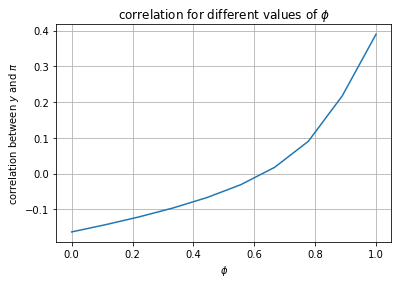

In [16]:
# a. look that the equilibrium correlation between y and pi for different values of phi
phi_q5 = np.linspace(0,1,10)

# b. create a dictionary for the lists that come out of the simulation for each phi-value
pi_dct = {}
y_dct = {}
corr = []

# c. run the simulation for each phi-value and save the correlation for each simulation in corr-list
for i,p in enumerate(phi_q5):
    pi_dct['pi_vec_q5_%s' % i], y_dct['y_vec_q5_%s' % i] = simulation(T, phi_q5[i])
    corr.append(np.corrcoef(y_dct['y_vec_q5_%s' %i], pi_dct['pi_vec_q5_%s' % i])[1,0])
    print(f'correlation between y and pi for phi = {p:.2f}: ', 
          np.corrcoef(y_dct['y_vec_q5_%s' %i], pi_dct['pi_vec_q5_%s' % i])[1,0])
    
# d. plot
fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)
ax.plot(phi_q5, corr)

# e. adjust plot
ax.grid()
ax.set_ylabel('correlation between $y$ and $\pi$')
ax.set_xlabel('$\phi$')
ax.set_title('correlation for different values of $\phi$')

**Answer:** The correlation is increasing and becomes positive for $\phi$ around 0.6. The correlation also grows faster and faster for higher values of $\phi$.

**Method:** For the $\phi$ that solves correlation = 0.31 see the next cell. I use a root-finder to solve the objective that is $\phi - 0.31$.

In [17]:
# a. define objective
obj = lambda phi: np.corrcoef(simulation(T, phi)[0], simulation(T, phi)[1])[1,0] - 0.31

# b. optimize for the root (where obj = 0)
phi_opt = optimize.root_scalar(obj, x0 = 0.8, bracket = [0,1], method = 'bisect')

# c. present result
solved = phi_opt.flag
phi_opt = phi_opt.root
print(f'the optimizer has', solved)
print(f'optimal phi: {phi_opt:.2f}')
print(f'test correlation for this phi: ', np.corrcoef(simulation(T, phi_opt)[0], simulation(T, phi_opt)[1])[1,0])

the optimizer has converged
optimal phi: 0.94
test correlation for this phi:  0.31000000000224054


**Answer:** For the correlation to be around 0.31, $\phi$ needs to be 0.94.

**Quesiton 6:** Use a numerical optimizer to choose $\sigma_x>0$, $\sigma_c>0$ and $\phi\in(0,1)$ to make the simulated statistics as close as possible to US business cycle data where:

1. $var(y_t) = 1.64$
2. $var(\pi_t) = 0.21$
3. $corr(y_t,\pi_t) = 0.31$
4. $corr(y_t,y_{t-1}) = 0.84$
5. $corr(\pi_t,\pi_{t-1}) = 0.48$

**Method:** The problem is not completely solved and the method is therefore described in detail: 

- Step a modifies the simulation-function to also take sigma_x and sigma_c as inputs and put the stochastic process inside the function. This could not be done in the original simulation-function as it would affect the plot in question 5 as x and c would be re-chosen in the loop.
- Step b defines the vector of parameters, which we want to optimize for.
- Step c defines the desired values for the variances and correlations to be equal to zero. This is done as I use them in sum in a objective.
- Step d defines the bounds on the parameters given in the question.
- Step e sets the initial guess equal to the phi found in question 5 and the old values of the sigmas.
- Step f is solution attempt 1. The solution should be found with optimize.minimize and the objective is the sum of all the differences between the desired values and the actual value in variances and correlations. This objective = 0 would yield the optimal vector of parameters. The problem is therefore obviously that the solver minimizes the objective < 0. I have tried to modify the solver e.g. by making an inequality constraint that the objective >= 0, but that doesn't work. To summarize: the optimizer converges but the solution is not correct as the objective gets minimized below the desired level = 0.
- Step g is solution attempt 2. As the first attempt have the problem that the objective is minimized, when I want to find a root to the problem I use optimize.root in the second solution attempt. optimize.root can only solve the same number of equations as the parameters to be optimized. Therefore only 3 of the desired inputs are used and then it should be investigated if the solution leads the last two inputs to be fulfilled as well. The optimizer doesn't converge, and therefore I never reach the point to investigate the omitted inputs. There also is a problem with this optimizer, as it doesn't take bounds into account. To summarize: the optimizer doesn't converge and cannot take the bounds into account.

Also I have tried some solutions with the desired variances and correlations used as constraints, but then I don't know what objective to optimize other than to pick one of the desired equations. But this give a problem of 1 equation with 3 unknowns. 

In [18]:
# a. modify the simulation function to also include the stochastic processs
def simulation2(T, phi_custom, sigma_x, sigma_c):  
    """
    returns (pi, y) for T simulations of the AS-AD model described above with more selective parameters
    
    parameters: 
        T: number of simulations
        phi_custom, sigma_x, sigma_c: see model description
    """
    # i. define stochastic process inside function
    x = np.random.normal(loc=0,scale=sigma_x,size=T)
    c = np.random.normal(loc=0,scale=sigma_c,size=T)
    
    # ii. initialize y_-1 = pi_-1 = s_-1 = v_-1 = 0
    pi_vec_q6 = [0]
    y_vec_q6 = [0]
    v_vec = [0]
    s_vec = [0]

    # iii. run simulation
    for t in range(1,T):

        # 1. update v and s
        v_vec.append(v_func(v_vec[t-1], x[t]))
        s_vec.append(s_func(s_vec[t-1], c[t]))

        # 2. compute y og pi 
        y_vec_q6.append(y_func(pi_vec_q6[t-1], y_vec_q6[t-1], v_vec[t], s_vec[t], s_vec[t-1],
                               alpha, h, b, phi_custom, gamma))
        pi_vec_q6.append(pi_func(pi_vec_q6[t-1], y_vec_q6[t-1], v_vec[t], s_vec[t], s_vec[t-1], 
                                 alpha, h, b, phi_custom, gamma))

    # iv. convert lists to numpy arrays
    pi_vec_q6 = np.array(pi_vec_q6)
    y_vec_q6 = np.array(y_vec_q6)
        
    return pi_vec_q6, y_vec_q6

# b. define the vector of parameters we want to optimize for
choose = [phi, sigma_x, sigma_c]

# c. define inputs to objective (the constraints)
var_y = np.var(simulation2(T, choose[0], choose[1], choose[2])[1]) - 1.64
var_pi = np.var(simulation2(T, choose[0], choose[1], choose[2])[0]) - 0.21
corr_ypi = np.corrcoef(simulation2(T, choose[0], choose[1], choose[2])[0],
                       simulation2(T, choose[0], choose[1], choose[2])[1])[1,0] - 0.31
corr_y = np.corrcoef(simulation2(T, choose[0], choose[1], choose[2])[1][1:], 
                     simulation2(T, choose[0], choose[1], choose[2])[1][:-1])[1,0] - 0.84
corr_pi = np.corrcoef(simulation2(T, choose[0], choose[1], choose[2])[0][1:],
                      simulation2(T, choose[0], choose[1], choose[2])[0][:-1])[1,0] - 0.48

# d. define bounds on the parameters
bounds = [[0,1], [0,50], [0,50]]

# e. set initial guess equal to already found values
x0 = np.array([phi_opt, sigma_x, sigma_c])

# f. solution attempt 1: use minimizer with bounds 
obj1 = lambda choose: var_y + var_pi + corr_ypi + corr_y + corr_pi
choose_opt1 = optimize.minimize(obj1, x0 = x0, bounds = bounds,  method='SLSQP')

# g. solution attempt 2: use root-finding 
obj2 = lambda choose: np.array([corr_ypi, corr_y, corr_pi])
choose_opt2 = optimize.root(obj2, x0 = x0)

# h. print both solution attempts
print(f'first attempt:', choose_opt1)
print(f'')
print(f'second attempt:', choose_opt2)

first attempt:      fun: -0.30464351572289067
     jac: array([0., 0., 0.])
 message: 'Optimization terminated successfully.'
    nfev: 5
     nit: 1
    njev: 1
  status: 0
 success: True
       x: array([0.94493442, 3.492     , 0.2       ])

second attempt:     fjac: array([[1., 0., 0.],
       [0., 1., 0.],
       [0., 0., 1.]])
     fun: array([-0.41924007, -0.84076389, -0.49866049])
 message: 'The iteration is not making good progress, as measured by the \n  improvement from the last ten iterations.'
    nfev: 17
     qtf: array([-0.41924007, -0.84076389, -0.49866049])
       r: array([-0.,  0.,  0., -0.,  0.,  0.])
  status: 5
 success: False
       x: array([0.94493442, 3.492     , 0.2       ])


# 3. Exchange economy

Consider an **exchange economy** with

1. 3 goods, $(x_1,x_2,x_3)$
2. $N$ consumers indexed by \\( j \in \{1,2,\dots,N\} \\)
3. Preferences are Cobb-Douglas with log-normally distributed coefficients

    $$ \begin{eqnarray*}
    u^{j}(x_{1},x_{2},x_{3}) &=& 
    \left(x_{1}^{\beta_{1}^{j}}x_{2}^{\beta_{2}^{j}}x_{3}^{\beta_{3}^{j}}\right)^{\gamma}\\
     &  & \,\,\,\beta_{i}^{j}=\frac{\alpha_{i}^{j}}{\alpha_{1}^{j}+\alpha_{2}^{j}+\alpha_{3}^{j}} \\
     &  & \,\,\,\boldsymbol{\alpha}^{j}=(\alpha_{1}^{j},\alpha_{2}^{j},\alpha_{3}^{j}) \\ 
     &  & \,\,\,\log(\boldsymbol{\alpha}^j) \sim \mathcal{N}(\mu,\Sigma) \\
    \end{eqnarray*} $$

4. Endowments are exponentially distributed,

$$
\begin{eqnarray*}
\boldsymbol{e}^{j} &=& (e_{1}^{j},e_{2}^{j},e_{3}^{j}) \\
 &  & e_i^j \sim f, f(z;\zeta) =  1/\zeta \exp(-z/\zeta)
\end{eqnarray*}
$$

Let $p_3 = 1$ be the **numeraire**. The implied **demand functions** are:

$$
\begin{eqnarray*}
x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j})&=&\beta^{j}_i\frac{I^j}{p_{i}} \\
\end{eqnarray*}
$$

where consumer $j$'s income is

$$I^j = p_1 e_1^j + p_2 e_2^j +p_3 e_3^j$$

The **parameters** and **random preferences and endowments** are given by:

In [19]:
# a. parameters
N = 50000
mu = np.array([3,2,1])
Sigma = np.array([[0.25, 0, 0], [0, 0.25, 0], [0, 0, 0.25]])
gamma = 0.8
zeta = 1

# b. random draws
seed = 1986
np.random.seed(seed)

# preferences
alphas = np.exp(np.random.multivariate_normal(mu, Sigma, size=N))
betas = alphas/np.reshape(np.sum(alphas,axis=1),(N,1))

# endowments
e1 = np.random.exponential(zeta,size=N)
e2 = np.random.exponential(zeta,size=N)
e3 = np.random.exponential(zeta,size=N)

**Question 1:** Plot the histograms of the budget shares for each good across agents.

Consider the **excess demand functions:**

$$ z_i(p_1,p_2) = \sum_{j=1}^N x_{i}^{\star j}(p_{1},p_{2},\boldsymbol{e}^{j}) - e_i^j$$

**Question 2:** Plot the excess demand functions.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

**Question 1:** Plot the histograms of the budget shares for each good across agents.

**Method:** In the Cobb-Douglas function where the power sums to 1 the power must be equal to the budget share for each good. Therefore the 3 betas are plotted below.

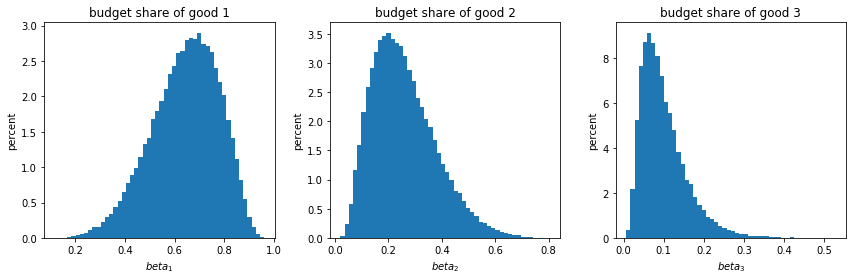

In [20]:
# a. create figure with 3 subplots
fig, ax = plt.subplots(1, 3)

# b. plot the betas
ax[0].hist(betas[:,0], bins = 50, density = True, histtype = 'bar')
ax[1].hist(betas[:,1], bins = 50, density = True, histtype = 'bar')
ax[2].hist(betas[:,2], bins = 50, density = True, histtype = 'bar')

# c. adjust the graphs
for i in range(3):
    ax[i].set_title(f'budget share of good {i+1}')
    ax[i].set_ylabel('percent')
    ax[i].set_xlabel(f'$beta_{i+1}$')
fig.set_figheight(4)
fig.set_figwidth(12)
fig.tight_layout()
plt.show()

**Answer:** The budget share of good 1 is a bit left skewed and centered around 0.65. The budget share of good 2 is right skewed and has a lower mean than good 1 about 0.25. The budget share of good 3 is more compact than the others and is centered around 0.1. This means that consumption of good 1 will use the largest share of the income: $\frac{p_1*x_1}{I}$ relative to the other goods.

**Question 2:** Plot the excess demand functions.

**Method:** Firstly the excess demand function is defined by creating the demand functions. After that it is plotted for good 1 and 2 for different values of $p_1$ and $p_2$. Excess demand is independent of $p_3$ as $p_3$ is numeraire and will therefore not be plotted for good 3.

In [21]:
# create functions for demand for each good

# demand for good 1 
def demand_g1(p1, p2, e1, e2, e3, betas):
    I = p1*e1 + p2*e2 + e3
    return betas[:,0]*I/p1 # use betas for good 1

# demand for good 2
def demand_g2(p1, p2, e1, e2, e3, betas):
    I = p1*e1 + p2*e2 + e3
    return betas[:,1]*I/p2 # use betas for good 2

# demand for good 3
def demand_g3(p1, p2, e1, e2, e3, betas):
    I = p1*e1 + p2*e2 + e3
    return betas[:,2]*I # use betas for good 3

# create excess demand functions

# excess demand for good 1
def excess_demand_1(p1, p2, e1, e2, e3, betas):
    
    # demand
    demand = np.sum(demand_g1(p1, p2, e1, e2, e3, betas))
    
    # supply
    supply = np.sum(e1)
    
    excess_demand_1 = demand - supply
    return excess_demand_1

# excess demand for good 2
def excess_demand_2(p1, p2, e1, e2, e3, betas):
    
    # demand
    demand = np.sum(demand_g2(p1, p2, e1, e2, e3, betas))
    
    # supply
    supply = np.sum(e2)
    
    excess_demand_2 = demand - supply
    return excess_demand_2

C:\Users\anine95\Anaconda3\lib\site-packages\ipykernel_launcher.py:6: RuntimeWarning: divide by zero encountered in true_divide
  
C:\Users\anine95\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: RuntimeWarning: divide by zero encountered in true_divide
  # This is added back by InteractiveShellApp.init_path()


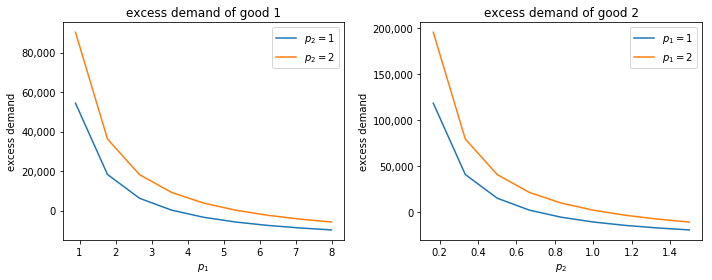

In [22]:
# a. create vectors with different prices
p1_vec = np.linspace(0, 8, 10)
p2_vec = np.linspace(0, 1.5, 10)

# b. prepare vectors
z_1_1 = []
z_1_2 = []
z_2_1 = []
z_2_2 = []

# c. calculate the excess demand for different prices and append to the vectors
for i in range(len(p1_vec)):
    z_1_1.append(excess_demand_1(p1_vec[i], 1, e1, e2, e3, betas)) # p2 = 1
    z_1_2.append(excess_demand_1(p1_vec[i], 2, e1, e2, e3, betas)) # p2 = 2
    z_2_1.append(excess_demand_2(1, p2_vec[i], e1, e2, e3, betas)) # p1 = 1
    z_2_2.append(excess_demand_2(2, p2_vec[i], e1, e2, e3, betas)) # p1 = 2

# d. plot the excess demand for good 1 and 2
fig,ax = plt.subplots(1,2)
ax[0].plot(p1_vec, z_1_1, label='$p_2 = 1$')
ax[0].plot(p1_vec, z_1_2, label='$p_2 = 2$')
ax[1].plot(p2_vec, z_2_1, label='$p_1 = 1$')
ax[1].plot(p2_vec, z_2_2, label='$p_1 = 2$')

# e. adjust the graphs
for i in range(2):
    ax[i].set_title(f'excess demand of good {i+1}')
    ax[i].set_ylabel('excess demand')
    ax[i].set_xlabel(f'$p_{i+1}$')
    ax[i].legend()
    ax[i].yaxis.set_major_formatter(mpl.ticker.StrMethodFormatter('{x:,.0f}'))

fig.set_figheight(4)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

**Answer:** From the plots we see that the excess demand for good 2 is more sensitive to different prices. When increasing $p_1$ in the plot for good 2 the excess demand function shifts to the right meaning that excess demand is higher for the same $p_2$. In equilibrium we want a combination where both excess demands is equal to 0. From this we will expect a higher equilibrium price for good 1 than for good 2.

**Quesiton 3:** Find the Walras-equilibrium prices, $(p_1,p_2)$, where both excess demands are (approximately) zero, e.g. by using the following tâtonnement process:

1. Guess on $p_1 > 0$, $p_2 > 0$ and choose tolerance $\epsilon > 0$ and adjustment aggressivity parameter, $\kappa > 0$.
2. Calculate $z_1(p_1,p_2)$ and $z_2(p_1,p_2)$.
3. If $|z_1| < \epsilon$ and $|z_2| < \epsilon$ then stop.
4. Else set $p_1 = p_1 + \kappa \frac{z_1}{N}$ and $p_2 = p_2 + \kappa \frac{z_2}{N}$ and return to step 2.

**Method:** The algorithm given is followed.

In [23]:
# step 1: guess on p1 and p2 (epsilon and kappa is defined in the function)
p1_0 = 1
p2_0 = 1

# create a function to find equilibrium
def find_equilibrium(p1, p2, e1, e2, e3, betas, kappa = 1, eps = 1e-8, maxiter = 5000):
    """
    returns the Walras-equilibrium prices (p1, p2) when p3 = 1 is numeraire
    
    parameters: see model description
    """
    t = 0
    while True:

        # a. step 2: excess demand
        Z1 = excess_demand_1(p1, p2, e1, e2, e3, betas)
        Z2 = excess_demand_2(p1, p2, e1, e2, e3, betas)
        
        # b: step 3: stop?
        if  (np.abs(Z1) < eps and np.abs(Z2) < eps) or t >= maxiter:
            print(f'{t:3d}: (p1, p2) = ({p1:.2f}, {p2:.2f}) => excess demand (z1, z2) => ({Z1:.2f}, {Z2:.2f})')
            break    
    
        # c. step 4: update p1 and p2 and return to step 2
        p1 = p1 + kappa*Z1/N
        p2 = p2 + kappa*Z2/N
                   
        t += 1    

    return p1, p2

# use the function to solve the problem
p1, p2 = find_equilibrium(p1_0, p2_0, e1, e2, e3, betas)

1415: (p1, p2) = (6.49, 2.62) => excess demand (z1, z2) => (0.00, 0.00)


**Answer:** From this we see that the optimal prices is $(p_1, p_2, p_3) = (6.49, 2.62, 1)$. This reflects the valuation of the goods relative to each other in the utility, $\beta_i^j$ and is consistent with the expectations described in question 1 and 2.

**Question 4:** Plot the distribution of utility in the Walras-equilibrium and calculate its mean and variance.

**Method:** The utility function is defined and then used to calculate the utility for each agent.

mean of utility: 2.38
variance of utility: 0.21


C:\Users\anine95\Anaconda3\lib\site-packages\matplotlib\figure.py:445: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  % get_backend())


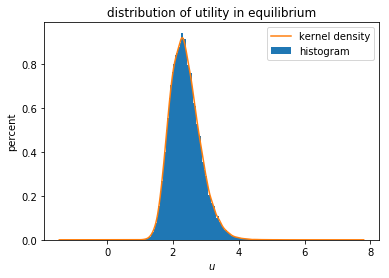

In [24]:
# a. define the utility function
def utility(x1, x2, x3, betas, gamma):
    return (x1**betas[:,0] + x2**betas[:,1] + x3**betas[:,2])**gamma

# b. get the demand for each good
x1 = demand_g1(p1, p2, e1, e2, e3, betas)
x2 = demand_g2(p1, p2, e1, e2, e3, betas)
x3 = demand_g3(p1, p2, e1, e2, e3, betas)

# c. calculate utility 
u = utility(x1, x2, x3, betas, gamma)

# d. calculate mean and variance on the distribution of utility
print(f'mean of utility: {u.mean():.2f}')
print(f'variance of utility: {u.var():.2f}')

# e. plot the distribution of utility in equilibrium
fig = plt.figure()
ax = fig.add_subplot(1,1,1)
ax.hist(u, bins = 100, density = True, label = 'histogram')
pd.Series(u).plot(kind = 'density', label = 'kernel density')

# f. adjust plot
ax.set_ylabel('percent')
ax.set_xlabel('$u$')
ax.legend()
ax.set_title('distribution of utility in equilibrium')
fig.show()

**Answer:** The utilities in equilibrium is approximately standard normal distributed around the mean = 2.38. It is a bit skewed to the right, but else it has a bell-shape.

**Question 5:** Find the Walras-equilibrium prices if instead all endowments were distributed equally. Discuss the implied changes in the distribution of utility. Does the value of $\gamma$ play a role for your conclusions?

**Method:** As the question asks to equally distributed endowments I look at the case, where everyone has the same endowments (homogenous). Alternatively I could have looked at endowments drawn from the uniform distribution (but that is not how I understand the question). Furthermore the kernel densities will not be showed in the graphs to keep them simple.

After the new endwoments are defined the prices, demands and utilities are found by the functions made in the earlier questions. The new utilities are compared to the old utilities for two different values of $\gamma$.

708: (p1, p2) = (6.45, 2.59) => excess demand (z1, z2) => (0.00, 0.00)


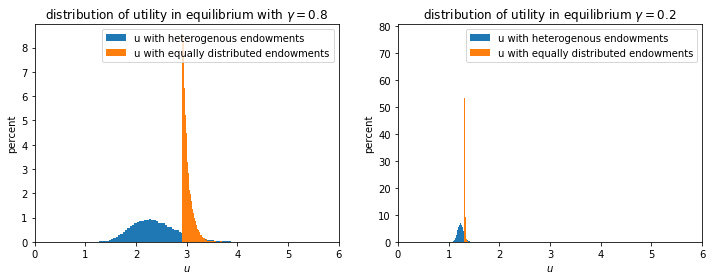

In [25]:
# a. set equally distributed endowments => everyone has (e1, e2, e3) = (2, 2, 2)
e1_new = np.full(N, 2)
e2_new = np.full(N, 2)
e3_new = np.full(N, 2)

# b. find prices in the new equilibrium
p1_new, p2_new = find_equilibrium(p1_0, p2_0, e1_new, e2_new, e3_new, betas)

# c. get the demand for each good in the new equilibrium
x1_new = demand_g1(p1_new, p2_new, e1_new, e2_new, e3_new, betas)
x2_new = demand_g2(p1_new, p2_new, e1_new, e2_new, e3_new, betas)
x3_new = demand_g3(p1_new, p2_new, e1_new, e2_new, e3_new, betas)

# d. find the new utilities
u_new = utility(x1_new, x2_new, x3_new, betas, gamma)

# e. plot the distribution of utility in original and new equilibrium for gamma = 0.8
fig, ax = plt.subplots(1, 2)
ax[0].hist(u, bins = 100, density = True, label = 'u with heterogenous endowments')
ax[0].hist(u_new, bins = 100, density = True, label = 'u with equally distributed endowments')

# f. adjust plot
ax[0].set_xlim([0, 6])
ax[0].legend()
ax[0].set_ylabel('percent')
ax[0].set_xlabel('$u$')
ax[0].set_title('distribution of utility in equilibrium with $\gamma = 0.8$')

# g. compare and plot the distributions of utilities for gamma = 0.2
u_gam = utility(x1, x2, x3, betas, 0.2)
u_new_gam = utility(x1_new, x2_new, x3_new, betas, 0.2)

ax[1].hist(u_gam, bins = 100, density = True, label = 'u with heterogenous endowments')
ax[1].hist(u_new_gam, bins = 100, density = True, label = 'u with equally distributed endowments')

# h. adjust plot
ax[1].set_xlim([0, 6])
ax[1].legend()
ax[1].set_ylabel('percent')
ax[1].set_xlabel('$u$')
ax[1].set_title('distribution of utility in equilibrium $\gamma = 0.2$')

fig.set_figheight(4)
fig.set_figwidth(10)
fig.tight_layout()
plt.show()

**Answer:** In the left graph we see that the distribution of utilities is much more compact with equally distributed endowments. Also the mean utility is higher for these endowments. The prices in the Walras-equilibrium is almost the same as with the other endowments. Differences can be due to precision of the optimizer. So the prices seem independent of the endowments.

The right graph makes it possible to compare the distribution with a new value of gamma. For this purpose it is convenient to retain the same x-axis as in the left graph. We see that the lower value of gamma shifts the utility to a lower level and decreases the variance in the distribution. But the comparison between the utility with heterogenous and equally distributed endowments is the same for the lower value of gamma namely that utilities with equally distributed endowments are more compact and have a higher mean. But it looks like the difference in mean between the two distributions in the right graph is smaller than with the higher value of gamma.